In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
import seaborn as sns
import omega_index

import sys
sys.path.append('../')
from CAS import *

# DBLP graph

* We load this dataset built from SNAP from a local pickle file with two components:
  * List of edges
  * List of communities

* Build igraph object 'G'

In [2]:
## read data
with open('../Datasets/DBLPFull.pkl', 'rb') as handle:
    b = pickle.load(handle)
Communities = b["Community lists"][:-1]
Edges = b['edges'][:-1]

# number of comms
print('number of GT communities:',len(Communities))

# community sizes
print('most common community sizes:')
print(Counter([len(x) for x in Communities]).most_common(10))

# number of edges
print('\nnumber of edges:',len(Edges))
G = ig.Graph.TupleList([tuple(e) for e in Edges])

# Dictionary: node name to node id
v_dct = {j:i for i,j in enumerate(G.vs['name'])}
print('number of nodes:',G.vcount(),'\n')

# store all communities for each node
for v in G.vs:
    v['comms'] = []
## append communities in 1-based format (we keep 0 for the outliers - no communities)
for i in range(len(Communities)):
    for v in Communities[i]:
        G.vs[v_dct[v]]['comms'].append(i+1)
G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
print('Number of memberships (most frequent):')
print(Counter(G.vs['n_comms']).most_common(10), '\n')

## Add community degrees to G (deg_A(v)'s)
for v in G.vs:
    ctr = Counter([i for x in v.neighbors() for i in x['comms']])
    v['degrees'] = [ctr[i] if i in ctr.keys() else 0 for i in v['comms'] ]

## Add pseudo single community ground truth: pick community with highest dev_A(v) for each v
G.vs['gt'] = [v['comms'][np.argmax(v['degrees'])] if len(v['degrees'])>0 else 0 for v in G.vs]


number of GT communities: 13477
most common community sizes:
[(6, 3680), (7, 2195), (8, 1461), (9, 1005), (10, 747), (11, 564), (12, 391), (13, 310), (14, 244), (16, 204)]

number of edges: 1049866
number of nodes: 317080 

Number of memberships (most frequent):
[(1, 150192), (0, 56082), (2, 43279), (3, 20163), (4, 11770), (5, 7909), (6, 5513), (7, 3915), (8, 3011), (9, 2332)] 



In [3]:
## eta
np.mean([x for x in G.vs['n_comms'] if x>0])

2.7579521682158483

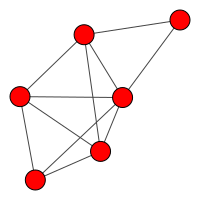

In [4]:
## Example of a community
V = [v_dct[x] for x in Communities[7]]
SG = G.subgraph(V)
ig.plot(SG, bbox=(200,200))


In [5]:
## Compute the external edge fraction given communities for each node
C = Counter([len(set(G.vs[e.source]['comms']).intersection(set(G.vs[e.target]['comms'])))>0 for e in G.es])
print('xi_hat =',C[0]/(C[0]+C[1]))


xi_hat = 0.1088738943827117


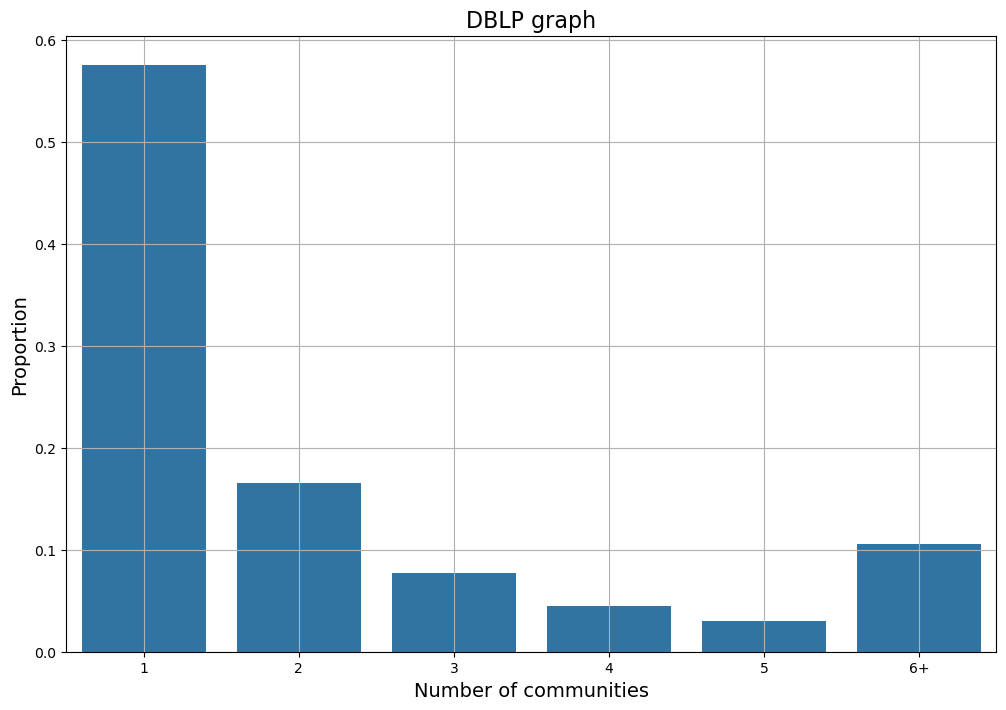

In [6]:
## community memberships
C = Counter(G.vs['n_comms'])
M = 6
m = max(C)
A = np.zeros(M)
for j in range(m):
    if j<M-1:
        A[j] = C[j+1]
    else:
        A[M-1] += C[j+1] 
            
df = pd.DataFrame()
df['memberships'] = [str(x) if x<M else str(M)+'+' for x in (np.arange(M)+1)]
#df['eta'] = np.repeat(ETA, M)
df['proportion'] = A/sum(A)
df.head()


plt.figure(figsize=(12,8))
sns.barplot(x="memberships", y="proportion", data=df);
plt.xlabel('Number of communities', fontsize=14);
plt.ylabel('Proportion', fontsize=14)
plt.grid()
#plt.legend(title=r'Value of $\eta$')
plt.title('DBLP graph', fontsize=16);
plt.savefig('dblp_eta.png')


In [ ]:
max([len(x) for x in Communities])

In [ ]:
## community size
C = Counter([len(x) for x in Communities])
plt.loglog(C.keys(),C.values(), '.');


In [ ]:
 len([len(x) for x in Communities if len(x)<=10]) / len(Communities)

In [ ]:
## community size
C = Counter([len(x) for x in Communities if len(x)<=500])
plt.loglog(C.keys(),C.values(), '.');


In [ ]:
import powerlaw
## estimates for l' (xmin) and gamma (alpha)
deg = [len(x) for x in Communities if len(x)<=500000]
X = powerlaw.Fit(deg)
print("\ngamma:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)


In [ ]:
## Starting from l'
fig1 = X.power_law.plot_ccdf(color="black", linestyle="-")
fig1 = X.plot_ccdf(ax=fig1, linewidth=2, color="gray", original_data=False, linestyle=":")
fig1.set_xlabel("size", fontsize=13)
fig1.set_ylabel("inverse cdf", fontsize=13);

In [ ]:
## community intersections?

## (1) sample at random from all communities
l = len(Communities)
L = []
n = G.vcount()
d = np.array(G.degree())/sum(G.degree())
for i in range(100000):
    r = np.random.choice(l, 2, replace=False)
    l1 = len(Communities[r[0]])
    l2 = len(Communities[r[1]])
    v1 = set(np.random.choice(n, l1, replace=False, p=d))
    v2 = set(np.random.choice(n, l2, replace=False, p=d))
    L.append([l1, l2, len(set(Communities[r[0]]).intersection(set(Communities[r[1]]))), len(v1.intersection(v2))])


In [ ]:
df  = pd.DataFrame(L, columns=['s1','s2','dblp','random'])
print(sum(df.dblp > df.random) , sum(df.dblp < df.random))


In [ ]:
X = df.dblp - df.random
sum([x for x in X if x!=0])

In [ ]:
df.sum()

In [ ]:
sns.violinplot([df.random[df.random>0],df.dblp[df.dblp>0]], log_scale=True)


### Clustering

* Leiden and compare with (single-community) GT


In [ ]:
%%time
G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
print('number of communities found:',max(G.vs['leiden']))
print('AMI:',AMI(G.vs['gt'], G.vs['leiden']))


### Post-processing

Compute the following measures and compare outliers found (no community ) with GT outliers:

* internal edge fraction (IEF)
* Beta score
* C score
* Pv (p-values) score


In [ ]:
%%time
A = G.get_adjacency_sparse()
IEF, Beta, C, Pv, DegPart = CAS(A, partition2sparse(G.vs['leiden']), alpha=1)


In [ ]:
## Thresholds below are somewhat arbitrary

M = score_to_memberships(IEF, DegPart, threshold=.25)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('IEF:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))

M = score_to_memberships(Beta, DegPart, threshold=.25)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('\nBeta score:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))

M = score_to_memberships(C, DegPart, threshold=3)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('\nC score:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))

M = score_to_memberships(Pv, DegPart, threshold=.95)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('\np-value score:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))


In [ ]:
## AMI with (single-community) GT
G.vs['IEF'] = IEF.argmax(axis=1).flatten().tolist()[0]
print('IEF:',AMI(G.vs['gt'], G.vs['IEF']))

G.vs['beta'] = Beta.argmax(axis=1).flatten().tolist()[0]
print('Beta:',AMI(G.vs['gt'], G.vs['beta']))

G.vs['C'] = C.argmax(axis=1).flatten().tolist()[0]
print('C score:',AMI(G.vs['gt'], G.vs['C']))

G.vs['Pv'] = Pv.argmax(axis=1).flatten().tolist()[0]
print('p-values:',AMI(G.vs['gt'], G.vs['Pv']))


# Figure in ABCD-oo WAW Paper

In [ ]:
## GT community membership matrix
X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
Y = np.array([i-1 for j in G.vs['comms'] for i in j])
n = len(X)
M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )
A = G.get_adjacency_sparse()

## Compute CAS measures
IEF, NIEF, C, Pv, DegPart = CAS(A, M, alpha=1)


In [ ]:
for x in [1,2,3,4]:
    L = []
    for i in range(G.vcount()):
        if G.vs[i]['n_comms'] == x:
            L.append(np.sort(np.array(NIEF[i].todense())[0])[-5:][::-1])
    df = pd.DataFrame(L, columns=['1','2','3','4','5'])
    plt.plot(df.mean(),'o-',label=str(x))
plt.grid()
plt.legend(title='Number of communities')
plt.xlabel('Rank', fontsize=13)
plt.ylabel('Mean NIEF', fontsize=13)
plt.title('DBLP Graph', fontsize=14)
plt.show()


# Figure 2a for CAS WAW paper

## Look at kth ranked communities

* proportion of k-th ranked community that is GT
* restrict to nodes with k+ communities and with 2+ community edges


In [ ]:
## GT community membership matrix
X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
Y = np.array([i-1 for j in G.vs['comms'] for i in j])
n = len(X)
M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )
A = G.get_adjacency_sparse()

## Compute CAS measures
IEF, Beta, C, Pv, DegPart = CAS(A, M, alpha=1)


In [ ]:
MAX = 25
MINDEG = 2

NumIEF = np.zeros(MAX)
NumBeta = np.zeros(MAX)
NumC = np.zeros(MAX)
NumPv = np.zeros(MAX)
Den = np.zeros(MAX)

for K in (np.arange(MAX)+1):
    V = np.array(G.vs['n_comms'])>=K
    minDeg = np.array([min(v['degrees']) if v['n_comms']>0 else 0 for v in G.vs]) >= MINDEG
    V = V & minDeg
    Si = Sb = Sc = Sp = 0
    for i in range(len(V)):
        if V[i]:
            x = np.argsort(IEF[i].toarray()[0])[-K]
            Si += ((x+1) in G.vs[i]['comms'])
            x = np.argsort(Beta[i].toarray()[0])[-K]
            Sb += ((x+1) in G.vs[i]['comms'])
            x = np.argsort(C[i].toarray()[0])[-K]
            Sc += ((x+1) in G.vs[i]['comms'])
            x = np.argsort(Pv[i].toarray()[0])[-K]
            Sp += ((x+1) in G.vs[i]['comms'])
            
    NumBeta[K-1] = Sb
    NumC[K-1] = Sc
    NumIEF[K-1] = Si
    NumPv[K-1] = Sp
    Den[K-1] = sum(V)

    print(K, Si, Sb, Sc, Sp, sum(V))

plt.plot(np.arange(MAX)+1, NumIEF/Den, '.-', label='IEF')
plt.plot(np.arange(MAX)+1, NumBeta/Den, '.-', label='NIEF')
#plt.plot(np.arange(MAX)+1, NumC/Den, '.-', label='C')
plt.plot(np.arange(MAX)+1, NumPv/Den, '.-', label='P score')
plt.xlabel('K (considering nodes with at least K ground-truth communities)')
plt.ylabel('P(Kth highest scoring is a true community)')
plt.legend()
plt.grid()
plt.title('DBLP graph',fontsize=14)
fn = 'dblp_ranked.png'
#plt.savefig(fn);


# Outlier detection

starting from Leiden - try starting with ego??

In [ ]:
A = G.get_adjacency_sparse()
## Leiden:
G.vs['leiden'] = G.community_leiden(objective_function='modularity', resolution=10).membership
IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(G.vs['leiden']))
max(G.vs['leiden'])

In [ ]:
# outliers
y = [int(x==0) for x in G.vs['gt']]
Counter(y)

In [ ]:
## Max CAS for outliers and other nodes
_df = pd.DataFrame()
_df['NIEF'] = Beta.max(axis=1).toarray().flatten()
_df['IEF'] = IEF.max(axis=1).toarray().flatten()
_df['P'] = P.max(axis=1).toarray().flatten()
_df['C'] = C.max(axis=1).toarray().flatten()

_df['Outlier'] = y
_df['deg'] = G.degree()

_df.groupby(by='Outlier').mean()


In [ ]:
### example - ego-net of outlier node
v = 302866
print(G.vs[v]['n_comms'], G.degree(v))


In [ ]:
[G.vs[v]['gt'] for v in G.neighborhood(v)]

In [ ]:
[G.vs[v]['leiden'] for v in G.neighborhood(v)]

In [ ]:
SG = G.subgraph(G.neighborhood(302866))
ig.plot(SG, bbox=(300,300))

## Running EgoSplit

In [ ]:
def EgoSplit(G, split='CC', algo='LP'):
    g = G.copy()
    ## implement ego-split approach with LP+LP and LP+ECG
    g.vs['original'] = g.vs['name']
    ## use the vertex names to avoid issues when vertices are re-mapped ...
    names = g.vs['name']
    ## step 1 - ego-net splits
    for nm in names:
        v = g.vs.find(nm).index
        n = g.neighbors(v)
        sg = g.subgraph(n)
        if split == 'LP':
            x = sg.community_label_propagation().membership
        else:
            x = sg.connected_components().membership
        if np.min(x)==-1:
            x = [i+1 for i in x]
        for j in set(x):
            g.add_vertex(name=nm+'.'+str(j),original=nm)

        l = sg.vs['name']
        for j in range(len(x)):
        g.add_edge(nm+'.'+str(x[j]) , l[j])
        g.delete_vertices(v)
    ## step 2 -- cluster w.r.t. multiple personae
    if algo=='LP':
        cl = g.community_label_propagation()
    else:
        cl = g.community_ecg(ens_size=32, final='leiden') ## Leiden
    C = [set(sg.vs['original']) for sg in cl.subgraphs()]
    return C


In [ ]:
G.vs['core'] = G.coreness()
V = np.where(np.array(G.vs['core']) > 2)[0]
SG = G.subgraph(V)
SG.vcount()

In [ ]:
%%time
Names = SG.vs['name']
SG.vs['name'] = [str(i) for i in np.arange(SG.vcount())]
comms_es = EgoSplit(SG, split='CC', algo='ECG')
ES = [list(x) for x in comms_es if len(x)>=10]    


In [ ]:
## given list of node memberships, return list of communities
def mems2comms(X):
    nc = max(set([i for j in X for i in j]))+1  
    n = len(X)
    L = [[] for _ in range(nc)]
    for i in range(n):
        for j in X[i]:
            L[j].append(i)
    return L


In [ ]:
GT = mems2comms(SG.vs['comms'])[1:]  ## ignore "outlier community"
_GT = [[str(i) for i in x] for x in GT]
GT = [x for x in _GT if len(x)>1]

In [ ]:
## input format: 
import csv
import subprocess
oNMI = '/Users/francois/Book/GraphMiningNotebooks/oNMI/onmi'          ## MAC - overlapping NMI executable
def compute_oNMI(First, Second):
    fn1 = '__'+str(random.random())[2:]
    with open(fn1,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(First)
    f.close()   

    fn2 = '__'+str(random.random())[2:]
    with open(fn2,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(Second)
    f.close()   
    x = float(subprocess.check_output([oNMI,fn1,fn2]).decode("utf-8").split()[1])
    _ = os.system('rm '+fn1)
    _ = os.system('rm '+fn2)
    return x


In [ ]:
compute_oNMI(GT,ES)

## Filter - min coreness and min comm size

In [ ]:
print(min(G.coreness()))
V = np.where(np.array(G.coreness())<5)[0]
G.delete_vertices(V)


In [ ]:
## GT community membership matrix
X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
Y = np.array([i-1 for j in G.vs['comms'] for i in j])
n = len(X)
M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )


In [ ]:
keep_col = np.where(np.array(M.sum(axis=0))[0] >= 10)[0]
len(keep_col)

In [ ]:
M = M[:,keep_col]

In [ ]:
G.vcount()

In [ ]:
for i in range(len(M.indptr)-1):
    G.vs[i]['comms'] = M.indices[M.indptr[i]:M.indptr[i+1]]

In [ ]:
G.vs[0]

In [ ]:
G.vs['n_comms'] = [len(x) for x in G.vs['comms']]

In [ ]:
A = G.get_adjacency_sparse()
## Leiden:
G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(G.vs['leiden']))


In [ ]:
y = [int(x>0) for x in G.vs['gt']]
Counter(y)

In [ ]:
G.vs['Beta'] = Beta.max(axis=1).toarray().flatten()
fpr, tpr, thresholds = roc_curve(y, G.vs['Beta'], pos_label=1)
auc = AUC(y, G.vs['Beta'])
plt.plot(fpr, tpr, label='Beta: '+str(round(auc,3)))

G.vs['P'] = P.max(axis=1).toarray().flatten()
fpr, tpr, thresholds = roc_curve(y, G.vs['P'], pos_label=1)
auc = AUC(y, G.vs['P'])
plt.plot(fpr, tpr, label='P: '+str(round(auc,3)))

plt.legend();


## oNMI

In [ ]:
## GT community membership matrix
X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
Y = np.array([i-1 for j in G.vs['comms'] for i in j])
n = len(X)
GT = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )


In [ ]:
def memberships2list(S):
    L = []
    for i in range(len(S.indptr)-1):
        if S.indptr[i] == S.indptr[i+1]:
            L.append([0]) ## no membership == outlier (community 0)
        else:
            L.append(list(S.indices[S.indptr[i]:S.indptr[i+1]]+1)) ## 1-based
    return L
def mem2comms(X):
    nc = max(set([i for j in X for i in j]))+1  
    n = len(X)
    L = [[] for _ in range(nc)]
    for i in range(n):
        for j in X[i]:
            L[j].append(i)
    return L

In [ ]:
import csv
import subprocess
oNMI = '/Users/francois/Book/GraphMiningNotebooks/oNMI/onmi'          ## overlapping NMI executable
#oNMI = '/work/home/fcthebe/Tools/oNMI/onmi'          ## overlapping NMI executable
def compute_oNMI(First, Second):
    fn1 = '__'+str(random.random())[2:]
    with open(fn1,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(First)
    f.close()   

    fn2 = '__'+str(random.random())[2:]
    with open(fn2,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(Second)
    f.close()   
    x = float(subprocess.check_output([oNMI,fn1,fn2]).decode("utf-8").split()[1])
    _ = os.system('rm '+fn1)
    _ = os.system('rm '+fn2)
    return x


In [ ]:
%%time
X = memberships2list(GT)


In [ ]:
G.vs['leiden'] = G.community_leiden(objective_function='modularity', resolution=1).membership
print('number of communities found:',max(G.vs['leiden']))
Leiden = mem2comms([[j] for j in G.vs['leiden']])
GT = mem2comms(G.vs['comms'])[1:]
ldn = compute_oNMI(GT, Leiden)
ldn

In [ ]:
IEF, Beta, C, Pv, DegPart = CAS(G.get_adjacency_sparse(), partition2sparse(G.vs['leiden']))


In [ ]:
TH = [.02,.04,.06,.08,.1]
for th1 in [.5,.55,.6,.65]:
    non_outliers = np.array((Beta >= th1).sum(axis=1)>0).flatten()
    for th2 in TH:
        if th2 <= th1:
            L = []
            for i in range(Beta.shape[1]):
                x = np.where( (np.array(Beta[:,i].todense()).flatten() >= th2) & non_outliers)[0]
                if len(x)>0:
                    L.append(list(x))
            print([th1, th2, G.vcount() - sum(non_outliers), compute_oNMI(GT,L), sum([len(x) for x in L]) / sum(non_outliers)])


# Experiment with overlapping ground-truth (gt) communities

* Input: membership (sparse) matrix M and (Sparse) adjacency A


In [ ]:
## GT community membership matrix
X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
Y = np.array([i-1 for j in G.vs['comms'] for i in j])
n = len(X)
M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )
A = G.get_adjacency_sparse()

## Compute CAS measures
IEF, Beta, C, Pv, DegPart = CAS(A, M, alpha=1)


In [ ]:
with open('Results/CAS_1.pkl','rb') as fp:
    IEF,Beta,C,Pv,DegPart = pickle.load(fp)

## k-communities

Look at nodes that are part of $k$ communities, with at least $l$ edges into each one of those, and compute average rank from each statistic


In [ ]:
plt.style.use('default')
K = 3

V = np.array(G.vs['n_comms'])==K
GT = np.array([G.vs[v]['comms'] for v in np.where(V)])[0] -1 ## map 1-based to 0-based
Degs = np.array([G.vs[v]['degrees'] for v in np.where(V)])[0]
plt.figure(figsize=(12,10))

## IEF
X = IEF[V]
L = []
for i in range(GT.shape[0]):
    x = np.argsort(X[i].toarray()[0])[::-1]
    L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
df = pd.DataFrame(np.array(L)+1)
my_dict = {}
for j in [1,2,3,4,5,6,7,8]:
    _df = df[np.min(Degs, axis=1) >= j]
    x = _df.mean(axis=1)
    my_dict[str(j)] = list(x)
plt.subplot(221)
plt.hlines((K+1)/2,1,8,linestyles='dotted')
ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
ax.set_xticks(np.arange(8))
ax.grid(linestyle=':')
ax.set_xticklabels(my_dict.keys())
plt.ylabel('average rank for '+str(K)+' communities', fontsize=12);
plt.title('IEF', fontsize=14);

## Beta
X = Beta[V]
L = []
for i in range(GT.shape[0]):
    x = np.argsort(X[i].toarray()[0])[::-1]
    L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
df = pd.DataFrame(np.array(L)+1)
my_dict = {}
for j in [1,2,3,4,5,6,7,8]:
    _df = df[np.min(Degs, axis=1) >= j]
    x = _df.mean(axis=1)
    my_dict[str(j)] = list(x)
plt.subplot(222)
plt.hlines((K+1)/2,1,8,linestyles='dotted')
ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
ax.set_xticks(np.arange(8))
ax.grid(linestyle=':')
ax.set_xticklabels(my_dict.keys())
#plt.xlabel('min community degree at least');
#plt.ylabel('average rank for '+str(K)+' communities');
plt.title('Beta', fontsize=14);

## C
X = C[V]
L = []
for i in range(GT.shape[0]):
    x = np.argsort(X[i].toarray()[0])[::-1]
    L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
df = pd.DataFrame(np.array(L)+1)
my_dict = {}
for j in [1,2,3,4,5,6,7,8]:
    _df = df[np.min(Degs, axis=1) >= j]
    x = _df.mean(axis=1)
    my_dict[str(j)] = list(x)
plt.subplot(223)
plt.hlines((K+1)/2,1,8,linestyles='dotted')
ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
ax.set_xticks(np.arange(8))
ax.grid(linestyle=':')
ax.set_xticklabels(my_dict.keys())
plt.xlabel('Minimum in-community degree', fontsize=12);
plt.ylabel('average rank for '+str(K)+' communities', fontsize=12);
plt.title('C', fontsize=14);

## Pv
X = Pv[V]
L = []
for i in range(GT.shape[0]):
    x = np.argsort(X[i].toarray()[0])[::-1]
    L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
df = pd.DataFrame(np.array(L)+1)
my_dict = {}
for j in [1,2,3,4,5,6,7,8]:
    _df = df[np.min(Degs, axis=1) >= j]
    x = _df.mean(axis=1)
    my_dict[str(j)] = list(x)
plt.subplot(224)
plt.hlines((K+1)/2,1,8,linestyles='dotted')
ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
ax.set_xticks(np.arange(8))
ax.grid(linestyle=':')
ax.set_xticklabels(my_dict.keys())
plt.xlabel('Minimum in-community degree', fontsize=12);
#plt.ylabel('average rank for '+str(K)+' communities');
plt.title('p-values', fontsize=14);

## save PNG
fn = 'dblp_2hops_'+str(K)+'.png'
plt.savefig(fn)


## Score distribution as function of community size

In [ ]:
score = []
gt = []
nc = []
for ctr in np.arange(1,16):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = IEF[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])-1
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['IEF','gt','number of communities'])


In [ ]:
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='IEF', hue='gt', data=D, 
                showfliers=False, legend='full')
leg = g.axes.get_legend()
leg.set_title('IEF scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fn = 'dblp_scores_IEF.png'
plt.savefig(fn);


In [ ]:
score = []
gt = []
nc = []
for ctr in np.arange(1,16):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = Beta[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])-1
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['Beta','gt','number of communities'])


In [ ]:
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='Beta', hue='gt', data=D, 
                showfliers=False, legend='full')
leg = g.axes.get_legend()
leg.set_title('Beta scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fn = 'dblp_scores_Beta.png'
plt.savefig(fn);

In [ ]:
score = []
gt = []
nc = []
for ctr in np.arange(1,16):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = C[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])-1
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['C','gt','number of communities'])


In [ ]:
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='C', hue='gt', data=D, 
                showfliers=False, legend='full')
leg = g.axes.get_legend()
leg.set_title('C scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fn = 'dblp_scores_C.png'
plt.savefig(fn);


In [ ]:
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='C', hue='gt', data=D, 
                showfliers=False, legend='full')
plt.ylim((0,30));
leg = g.axes.get_legend()
leg.set_title('C scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fn = 'dblp_scores_C_zoom.png'
plt.savefig(fn);


In [ ]:
score = []
gt = []
nc = []
for ctr in np.arange(1,16):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = Pv[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])-1
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['Pv','gt','number of communities'])


In [ ]:
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='Pv', hue='gt', data=D, 
                showfliers=False, legend='full')
plt.ylabel('P-score')
leg = g.axes.get_legend()
leg.set_title('P scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fn = 'dblp_scores_P.png'
plt.savefig(fn);


In [ ]:
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='Pv', hue='gt', data=D, 
                showfliers=False, legend='full')
plt.ylabel('P-score')
plt.ylim((.99,1));
leg = g.axes.get_legend()
leg.set_title('P scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fn = 'dblp_scores_P_zoom.png'
plt.savefig(fn);


## Absolute and Relative

Consider a node $i$ as part of a community $j$ if one of the folowing is true:

* $\beta_{i,j} \ge \beta^{*}$, for example $\beta^{*} = 0.75$
* $\beta_{i,j}$ is above $Q^{th}$ quantile of all values $\{\beta_{i,*} > 0\}$
* also min number of edges



In [ ]:
## IQR
Q = betastar = .75
MINDEG = 2

gt = []
nc = []
total = []
minDeg = np.array([min(v['degrees']) if v['n_comms']>0 else 0 for v in G.vs]) >= MINDEG

for ctr in np.arange(1,16):
    V = np.array(G.vs['n_comms']) == ctr
    V = V & minDeg
    for i in range(len(V)):
        if V[i]:
            x = Beta[i].toarray()[0]
            th = min(np.quantile(x[x>0], Q), betastar)
            l = len(set(np.where(x>th)[0]).intersection(set(np.array(G.vs[i]['comms'])-1)))
            gt.append(l)
            total.append(sum(x>th))
            nc.append(ctr)
D = pd.DataFrame( np.array([total,gt,nc]).transpose(), columns=['total', 'gt', 'number of communities'])


In [ ]:
sns.boxplot(x = [int(i) for i in D['number of communities']], 
            y = D['gt'], 
            showfliers=False );
plt.grid()
plt.xlabel('number of GT communities')
plt.ylabel('number of GT Beta above Q('+str(Q)+') or 0.75')
plt.plot([0,14],[1,15], color='red');
fn = 'dblp_beta_75_a.png'
plt.savefig(fn);

In [ ]:
sns.boxplot(x = [int(i) for i in D['number of communities']], 
            y = D['total'], 
            showfliers=False );
plt.grid()
plt.xlabel('number of GT communities')
plt.ylabel('number of Beta above Q('+str(Q)+') or 0.75')
plt.plot([0,14],[1,15], color='red');
fn = 'dblp_beta_75_b.png'
plt.savefig(fn);


In [ ]:
D['prop'] = D['gt'] / D['total']
sns.boxplot(x = [int(i) for i in D['number of communities']], 
            y = D['prop'], 
            showfliers=False );
plt.grid()
plt.xlabel('number of GT communities')
plt.ylabel('P(GT) if above Q('+str(Q)+') or 0.75');
fn = 'dblp_beta_75_c.png'
plt.savefig(fn);


# Edge classification

* first we do EDA - size of intersections of incident nodes


In [ ]:
## read data
with open('../Datasets/DBLPFull.pkl', 'rb') as handle:
    b = pickle.load(handle)
Communities = b["Community lists"][:-1]
Edges = b['edges'][:-1]
G = ig.Graph.TupleList([tuple(e) for e in Edges])

# Dictionary: node name to node id
v_dct = {j:i for i,j in enumerate(G.vs['name'])}

# store all communities for each node
for v in G.vs:
    v['comms'] = []
## append communities in 1-based format (we keep 0 for the outliers - no communities)
for i in range(len(Communities)):
    for v in Communities[i]:
        G.vs[v_dct[v]]['comms'].append(i+1)
G.vs['n_comms'] = [len(x) for x in G.vs['comms']]

## Add community degrees to G (deg_A(v)'s)
for v in G.vs:
    ctr = Counter([i for x in v.neighbors() for i in x['comms']])
    v['degrees'] = [ctr[i] if i in ctr.keys() else 0 for i in v['comms'] ]


In [ ]:
## EDA on the edges
G.es['gt'] = [len(set(G.vs[e.source]['comms']).intersection(set(G.vs[e.target]['comms']))) for e in G.es]
Counter(G.es['gt'])

In [ ]:
ECG = G.community_ecg(ens_size=32,final='leiden', refuse_score=True)


In [ ]:
np.corrcoef(np.array(ECG.W), np.array(G.es['gt']))

In [ ]:
plt.plot(np.array(ECG.W), np.array(G.es['gt']),'.');